In [1]:
import pandas as pd
from config import *

df = pd.read_csv(all)

C:\Users\benja\AppData\Local\Temp\ipykernel_21996\2130263240.py:4: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(all)


In [2]:
from filtering import formatDF, discretizarDatos
data = formatDF(df)
data.loc[data["vendedor"].isna(), "vendedor"] = data.loc[data["vendedor"].isna(), "tipoVendedor"]
data = discretizarDatos(data)

# drop columns: activo, URL, file, tipoVendedor, ciudad
data = data.drop(['activo', 'URL', 'file', 'tipoVendedor','ciudad'], axis=1)
data = data.loc[data["tipoPropiedad"] != 3]

C:\Users\benja\AppData\Local\Temp\ipykernel_21996\3188576236.py:2: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  data = formatDF(df)


In [3]:
barrios = pd.read_csv("./utils/barrios.csv")

data.loc[:, "barrioID"] = -1

# asignar index de barrios en barrioID
for barrio in barrios["barrio"]:
    data.loc[data["barrio"] == barrio, "barrioID"] = barrios.loc[barrios["barrio"] == barrio].index[0]

for b in data.loc[data["barrioID"] == -1, "barrio"].unique():
    data.loc[data["barrio"] == b, "barrioID"] = data["barrioID"].max()+1

In [4]:
import datetime

# eliminar rows con "fechaUltimaActualizacion" > 2023-11-15
data['fechaUltimaActualizacion'] = pd.to_datetime(data['fechaUltimaActualizacion'])
data = data.loc[data["fechaUltimaActualizacion"] < datetime.datetime(2023, 11, 15)]

# crear columnas ano, mes, dia
data["ano"] = data["fechaUltimaActualizacion"].dt.year
data["mes"] = data["fechaUltimaActualizacion"].dt.month
data["dia"] = data["fechaUltimaActualizacion"].dt.day

c:\Users\benja\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] El sistema no puede encontrar el archivo especificado
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\benja\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "c:\Users\benja\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 501, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\Users\benja\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 966, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\benja\AppData\Local\Programs\Python\Python

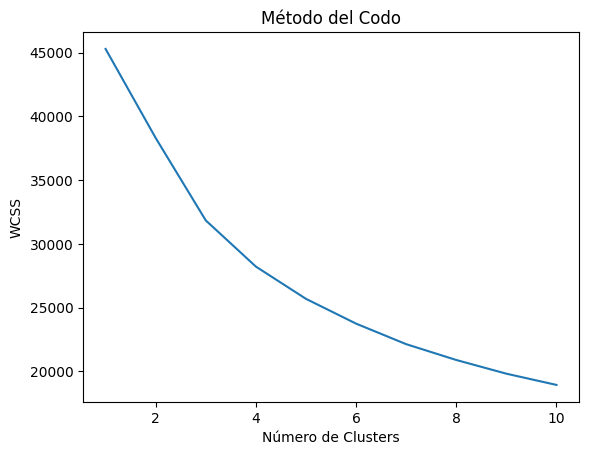

In [28]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

features = ['terrenoEdificado', 'coordX', 'coordY', 'barrioID', 'ano', 'mes', 'dia']
data_for_clustering = data[features]

scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_for_clustering)

# Escalar los datos para que todas las características tengan la misma escala

# Determinar el número óptimo de clusters utilizando el método del codo
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=100, random_state=33)
    kmeans.fit(scaled_data)
    wcss.append(kmeans.inertia_)

# Visualizar el método del codo para encontrar el número óptimo de clusters
plt.plot(range(1, 11), wcss)
plt.title('Método del Codo')
plt.xlabel('Número de Clusters')
plt.ylabel('WCSS')  # Within-Cluster Sum of Squares
plt.show()


In [85]:
n_clusters = 7
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=500, n_init=200, random_state=42)
clusters = kmeans.fit_predict(scaled_data)

# Agregar la información de los clusters al DataFrame original
data['clusterKM'] = clusters

In [5]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

features_knn = ['terrenoEdificado', 'comisariaCercana', 'transporteCercano', 
                'saludCercana', 'coordX', 'coordY', 'barrioID', 'ano', 'mes', 'dia']

data_for_knn_train = data[features_knn]
target_column = 'precioUSD'
target = data[target_column]

# train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_for_knn_train, target, train_size=0.99, random_state=33)

# Eliminar train_test_split y usar todo el conjunto de entrenamiento
scaler_knn = StandardScaler()
X_train_scaled = scaler_knn.fit_transform(X_train)

# Crear instancias de modelos con diferentes configuraciones
models = dict()
r2_scores = []
for i in range(1, 20):
    models[f'knn{i}'] = KNeighborsRegressor(n_neighbors=i, weights='distance', algorithm='ball_tree')
    m = KNeighborsRegressor(n_neighbors=i, weights='distance', algorithm='ball_tree')
    m.fit(X_train_scaled, y_train)
    scores_r2 = cross_val_score(m, X_train_scaled, y_train, cv=5, scoring='r2')
    r2_scores.append((f'knn{i}', scores_r2.mean()))

In [6]:
r2_scores

[('knn1', 0.5016932408634637),
 ('knn2', 0.6208670560136775),
 ('knn3', 0.6552755199883792),
 ('knn4', 0.6687579946138122),
 ('knn5', 0.6754080512051187),
 ('knn6', 0.6807399322873596),
 ('knn7', 0.6810997428087466),
 ('knn8', 0.6818529980868483),
 ('knn9', 0.6810207656642313),
 ('knn10', 0.6811865729554027),
 ('knn11', 0.6804867812975521),
 ('knn12', 0.679151884512477),
 ('knn13', 0.678754414244763),
 ('knn14', 0.6790907014144796),
 ('knn15', 0.6777649394431687),
 ('knn16', 0.6759979353484894),
 ('knn17', 0.6744344473367455),
 ('knn18', 0.6732211510462411),
 ('knn19', 0.6714644199873268)]

Utilizando KMeans antes

[('knn1', 0.48214737276671976),
 ('knn2', 0.6010315511020512),
 ('knn3', 0.6386800598778829),
 ('knn4', 0.6557450956686133),
 ('knn5', 0.6614565494300259),
 ('knn6', 0.6654284684224038),
 ('knn7', 0.664787090908411),
 ('knn8', 0.6656802726263734),
 ('knn9', 0.6648589468063458),
 ('knn10', 0.6658784801355613),
 ('knn11', 0.6646382073303065),
 ('knn12', 0.662766173785444),
 ('knn13', 0.6610567063550378),
 ('knn14', 0.6590800487629626),
 ('knn15', 0.6574183605260213),
 ('knn16', 0.656544875755529),
 ('knn17', 0.6551338845306174),
 ('knn18', 0.6540304826373113),
 ('knn19', 0.6536244874986004)]

In [9]:
from sklearn.ensemble import RandomForestRegressor

print("Creando Random Forest...")

random_forest_model = RandomForestRegressor(n_estimators=200, random_state=42, max_depth=17)
random_forest_model.fit(X_train_scaled, y_train)
scores_r2 = cross_val_score(random_forest_model, X_train_scaled, y_train, cv=5, scoring='r2')
      
print(f"Random Forest: r2 = {scores_r2.mean()}")

Creando Random Forest...
depth = 15
depth = 16
depth = 17
depth = 18
Random Forest: r2 = 0.7710382082308733, depth = 17


In [10]:
from sklearn.ensemble import GradientBoostingRegressor

print("Creando XGBoost...")

gradient_boosting_model = GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, max_depth=8, random_state=42)
gradient_boosting_model.fit(X_train_scaled, y_train)
scores_r2 = cross_val_score(gradient_boosting_model, X_train_scaled, y_train, cv=5, scoring='r2')

print(f"XGBoost: r2 = {scores_r2.mean()}")

Creando XGBoost...
depth = 5
r2 = 0.7520419555592107

depth = 6
r2 = 0.7676468382264419

depth = 7
r2 = 0.7764063824387633

depth = 8
r2 = 0.7776806204173445

depth = 9
XGBoost: r2 = 0.7776806204173445, depth = 8


In [11]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

print("Creando AdaBoost...")

ada_boost_model = AdaBoostRegressor(DecisionTreeRegressor(max_depth=15), n_estimators=200, random_state=42)
ada_boost_model.fit(X_train_scaled, y_train)
scores_r2 = cross_val_score(ada_boost_model, X_train_scaled, y_train, cv=5, scoring='r2')
    
print(f"AdaBoost: r2 = {scores_r2.mean()}")

Creando AdaBoost...
depth = 5
r2 = 0.5981461276471467

depth = 6
r2 = 0.675025318682686

depth = 7
r2 = 0.7248430082340545

depth = 8
r2 = 0.750322660846213

depth = 9
r2 = 0.7652853470493147

depth = 10
r2 = 0.7771922412849539

depth = 11
r2 = 0.7844711730964299

depth = 12
r2 = 0.7865511913117913

depth = 13
r2 = 0.7884459097077225

depth = 14
r2 = 0.788471193909685

depth = 15
r2 = 0.7885201734604115

depth = 16
AdaBoost: r2 = 0.7885201734604115, depth = 15


In [15]:
sorted_models = [model[0] for model in sorted(r2_scores, key=lambda x: x[1], reverse=True)][:4]
models_w_weight = []
weights = [3,3,2,2]
for i in range(len(weights)):
    models_w_weight.append(((sorted_models[i], models[sorted_models[i]]), weights[i]))
    
models_w_weight.append((('RF', 
    RandomForestRegressor(n_estimators=800, random_state=42, max_depth=17)), 5))
models_w_weight.append((('XGBoost', 
    GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, max_depth=8, random_state=42)), 5))
models_w_weight.append((('AdaBoost', 
    AdaBoostRegressor(DecisionTreeRegressor(max_depth=15), n_estimators=200, random_state=42)), 5))

In [16]:
from sklearn.ensemble import VotingRegressor

ensemble_model = VotingRegressor(estimators=[model[0] for model in models_w_weight], 
                                 weights=[w[1] for w in models_w_weight])
ensemble_model.fit(X_train_scaled, y_train)

# Escalar todos los datos
X_testing = X_test.copy()
X_test_scaled = scaler_knn.transform(X_test)
all_data_predictions = ensemble_model.predict(X_test_scaled)
X_testing.loc[:, 'precioUSDPredicted'] = all_data_predictions
X_testing.loc[:, "precioUSD"] = y_test

ensemble_r2 = cross_val_score(ensemble_model, X_train_scaled, y_train, cv=5, scoring='r2')

# Imprimir resultados
print(f"R^2 en el conjunto de prueba para el modelo ensamblado: {ensemble_r2}")

R^2 en el conjunto de prueba para el modelo ensamblado: [0.76615933 0.77174817 0.79242737 0.76758428 0.76543424]


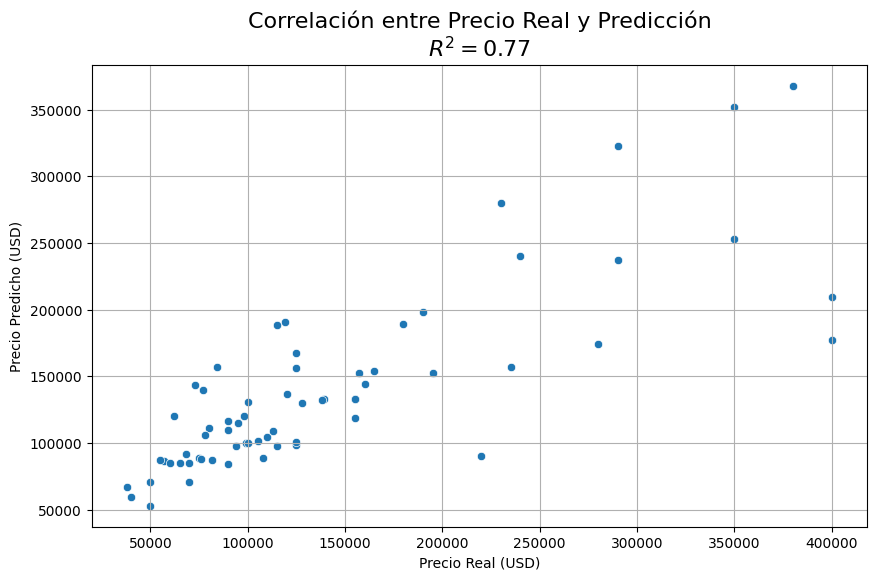

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Crea un gráfico de dispersión
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=all_data_predictions)
plt.title(f'Correlación entre Precio Real y Predicción\n$R^2={ensemble_r2.mean():.2f}$', fontsize=16)
plt.xlabel('Precio Real (USD)')
plt.ylabel('Precio Predicho (USD)')
plt.grid(True)
plt.show()

In [18]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Calcular los residuos del modelo ensamblado
residuals = y_test - all_data_predictions

residual_boosting_model = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=9),
                                            n_estimators=100, random_state=42)
residual_boosting_model.fit(X_test_scaled, residuals)

residual_predictions_boosting = residual_boosting_model.predict(X_test_scaled)
corrected_predictions_boosting = all_data_predictions + residual_predictions_boosting
corrected_r2_boosting = r2_score(y_test, corrected_predictions_boosting)

corrected_rmse_boosting = np.sqrt(mean_squared_error(y_test, corrected_predictions_boosting))

print(f"R^2 para el modelo ensamblado corregido con residuos de boosting: {corrected_r2_boosting}")
print(f"RMSE del modelo ensamblado corregido con residuos de boosting: {corrected_rmse_boosting}")

c:\Users\benja\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


R^2 para el modelo ensamblado corregido con residuos de boosting: 0.9947395741224686
RMSE del modelo ensamblado corregido con residuos de boosting: 6537.292506351021


R^2 en el conjunto de prueba para el modelo corrector derivado: 0.997076451379181
RMSE del modelo corrector derivado: 4873.518570380156


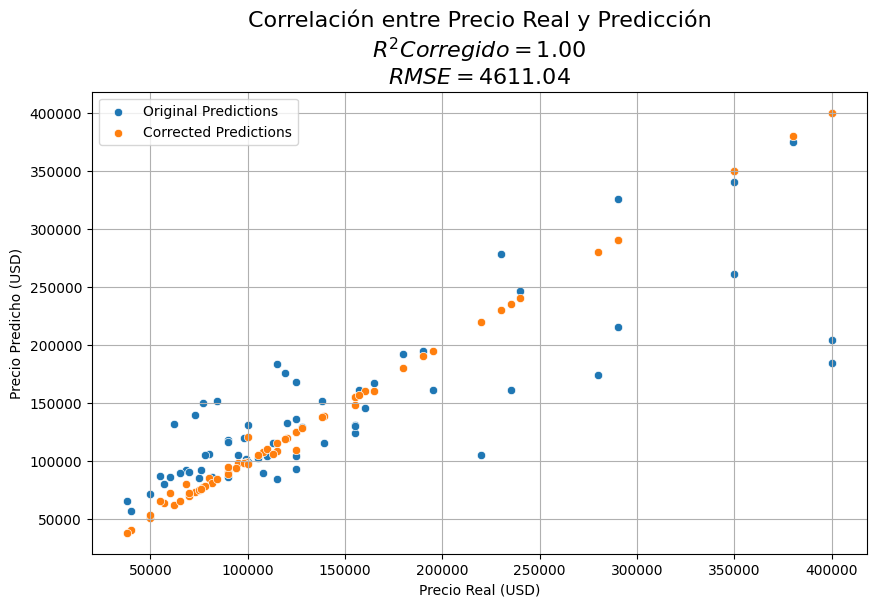

In [109]:
# importar librerías
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score


# Combinar las predicciones corregidas de cada modelo con los pesos
ensemble_corrected_predictions = (corrected_predictions_boosting)

# Calcular el R^2 y RMSE para el modelo ensamblado
ensemble_r2 = r2_score(y_test, ensemble_corrected_predictions)
ensemble_rmse = np.sqrt(mean_squared_error(y_test, ensemble_corrected_predictions))

# Calcular la línea de mejor ajuste
fit_line = np.polyfit(y_test, ensemble_corrected_predictions, 1)
fit_line_equation = np.poly1d(fit_line)

# Calcular predicciones según la línea de mejor ajuste
fit_line_predictions = fit_line_equation(ensemble_corrected_predictions)

fit_line_r2 = r2_score(y_test, fit_line_predictions)
fit_line_rmse = np.sqrt(mean_squared_error(y_test, fit_line_predictions))

print(f"R^2 en el conjunto de prueba para el modelo corrector derivado: {fit_line_r2}")
print(f"RMSE del modelo corrector derivado: {fit_line_rmse}")

# Crear un gráfico de dispersión para comparar las predicciones originales y corregidas
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=all_data_predictions, label='Original Predictions')
sns.scatterplot(x=y_test, y=ensemble_corrected_predictions, label='Corrected Predictions')
# Titulo: con R^2 del modelo corrector derivado y RMSE redondeados a 2dp
plt.title(f'Correlación entre Precio Real y Predicción\n$R^2 Corregido={fit_line_r2:.2f}$\n$RMSE={ensemble_rmse:.2f}$', fontsize=16)
plt.xlabel('Precio Real (USD)')
plt.ylabel('Precio Predicho (USD)')
plt.legend()
plt.grid(True)
plt.show()